# Introduction

This notebook trains and evaluates a PyTorch CNN-model on the task of classifying images from the CIFAR10 dataset https://www.cs.toronto.edu/~kriz/cifar.html. I made it with the intent of learning PyTorch and it is based on the "Training a Classifier" tutorial from the PyTorch web site https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. The source code can be found at https://github.com/CarlFredriksson/image_classification_using_pytorch.

Let us start by importing some modules.

In [5]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Prepare Data

The output of torchvision datasets are PILImage images with pixel values in the range [0,1]. We need to transform the images to PyTorch tensors and normalize their pixel values to be in the range [-1,1]. The transform `RandomHorizontalFlip` is a form of data augmentation that increases the size of training set by randomly flipping images horizontally with a given probability (0.5 by default) every time they are loaded. Increasing the size of the training set generally helps reduce overfitting and adding the `RandomHorizontalFlip` increased the final test accuracy. However, I tried a couple of the other data augmentation transforms and did not see an improvement in performance.

In [8]:
# Prepare training data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# Prepare test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('Number of training examples:', len(train_set))
print('Number of test examples:', len(test_set))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 50000
Number of test examples: 10000


# Display Data

Let us display some images from the training set to see what we are working with.

In [9]:
def imshow(img):
    img = img / 2 + 0.5 # Un-normalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

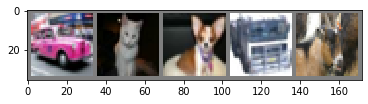

Labels: car cat dog truck deer


In [10]:
# Show some random training images
NUM_IMAGES_TO_SHOW = 5
data_iter = iter(train_loader)
images, labels = data_iter.next()
imshow(torchvision.utils.make_grid(images[:NUM_IMAGES_TO_SHOW]))
print('Labels:', ' '.join(f'{classes[labels[i]]}' for i in range(NUM_IMAGES_TO_SHOW)))

# Create Model

I tried several simple CNN-models and ended up with the one below. It does not achieve state of the art performance by any means but it is decent. The model uses the common pattern of convolutional layers (+ ReLU activation function) that increase the number of channels but does not change the dimensions (height and width) followed by max pooling layers for dimensionality reduction (downsampling). A famous architecture that use this pattern is VGG16, introduced in (Simonyan, Zisserman, 2014, https://arxiv.org/abs/1409.1556). However, VGG16 is much deeper and has multiple convolutional layers per pooling layer. At the time of writing this notebook there is no option to specify `padding='SAME'` as in TensorFlow, which means that we have to do the padding calculations ourselves. Let $H_{in}, W_{in}$ be the height and width of the input and $H_{out}, W_{out}$ be the height and width of the output. Then

$$
H_{out} = \frac{H_{in} + 2 \times \text{padding}[0] - \text{dilation}[0] \times (\text{kernel_size}[0] - 1) - 1}{\text{stride}[0]} + 1 \\
W_{out} = \frac{W_{in} + 2 \times \text{padding}[1] - \text{dilation}[1] \times (\text{kernel_size}[1] - 1) - 1}{\text{stride}[1]} + 1
$$

When `padding[0] = padding[1]`, `kernel_size[0] = kernel_size[1]`, `dilation[0] = dilation[1] = 1` (default), and `stride[0] = stride[1] = 1` (default), the equations can be reduced to

$$
H_{out} = H_{in} + 2 \times \text{padding} - \text{kernel_size} + 1 \\
W_{out} = W_{in} + 2 \times \text{padding} - \text{kernel_size} + 1
$$

A dropout layer is added between the first and second fully connected layers to reduce overfitting. Note that there is no need to add a soft-max layer after the last fully connected layer, since it is added automatically by `torch.nn.CrossEntropyLoss()` during training and it is not needed during inference because argmax does not get affected by applying soft-max. 

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # x size: N x 3 x 32 x 32
        x = F.relu(self.conv1(x))  # N x 16 x 32 x 32
        x = self.pool(x) # N x 16 x 16 x 16
        x = F.relu(self.conv2(x)) # N x 32 x 16 x 16
        x = self.pool(x) # N x 32 x 8 x 8
        x = F.relu(self.conv3(x)) # N x 64 x 8 x 8
        x = self.pool(x) # N x 64 x 4 x 4
        x = x.view(-1, 64 * 4 * 4) # N x 1024
        x = F.relu(self.fc1(x)) # N x 128
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # N x 64
        x = self.fc3(x) # N x 10
        return x

In [13]:
# Create model
net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
print('Device:', device)

Device: cuda:0


In [14]:
# Create optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train model

In [15]:
def compute_test_accuracy():
    num_total = len(test_set)
    num_correct = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            predictions = torch.argmax(outputs.data, 1)
            num_correct += (predictions == labels).sum().item()
    return num_correct / num_total

In [16]:
print('Number of iterations per epoch:', len(train_loader))

Number of iterations per epoch: 391


In [17]:
# Train model
NUM_EPOCHS = 100
loss_per_epoch = np.zeros(NUM_EPOCHS)
accuracy_per_epoch = np.zeros(NUM_EPOCHS)
test_accuracy_per_epoch = np.zeros(NUM_EPOCHS)
print('Starting training')
start_time = time.perf_counter()
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        predictions = torch.argmax(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_per_epoch[epoch] += loss.item() / len(train_loader)
        accuracy_per_epoch[epoch] += (predictions == labels).sum().item() / len(train_set)
    # Compute test accuracy
    net.train(False)
    test_accuracy_per_epoch[epoch] = compute_test_accuracy()
    net.train(True)

    # Print statistics
    print('Epoch [{}/{}] loss: {:.5f} accuracy: {:.2f}% test accuracy: {:.2f}%'.format(
        epoch, NUM_EPOCHS - 1, loss_per_epoch[epoch],
        100 * accuracy_per_epoch[epoch],
        100 * test_accuracy_per_epoch[epoch]))
elapsed_time = time.perf_counter() - start_time
print(f'Finished training - elapsed_time: {elapsed_time:.0f} sec')

Starting training
Epoch [0/99] loss: 2.30292 accuracy: 10.00% test accuracy: 10.00%
Epoch [1/99] loss: 2.30197 accuracy: 10.10% test accuracy: 10.02%
Epoch [2/99] loss: 2.30075 accuracy: 13.11% test accuracy: 17.50%
Epoch [3/99] loss: 2.29823 accuracy: 16.15% test accuracy: 16.91%
Epoch [4/99] loss: 2.28915 accuracy: 18.50% test accuracy: 17.03%
Epoch [5/99] loss: 2.21379 accuracy: 18.53% test accuracy: 21.67%
Epoch [6/99] loss: 2.03696 accuracy: 24.07% test accuracy: 28.86%
Epoch [7/99] loss: 1.89468 accuracy: 29.32% test accuracy: 34.49%
Epoch [8/99] loss: 1.75946 accuracy: 34.63% test accuracy: 37.36%
Epoch [9/99] loss: 1.67953 accuracy: 37.40% test accuracy: 39.07%
Epoch [10/99] loss: 1.62742 accuracy: 39.68% test accuracy: 41.12%
Epoch [11/99] loss: 1.58473 accuracy: 41.47% test accuracy: 42.98%
Epoch [12/99] loss: 1.53686 accuracy: 43.44% test accuracy: 45.66%
Epoch [13/99] loss: 1.49044 accuracy: 45.27% test accuracy: 46.76%
Epoch [14/99] loss: 1.45042 accuracy: 46.89% test accu

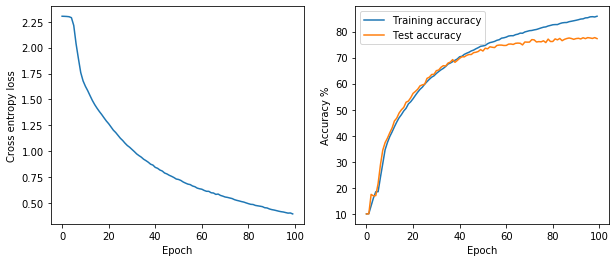

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(np.arange(NUM_EPOCHS), loss_per_epoch)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Cross entropy loss')
ax[1].plot(np.arange(NUM_EPOCHS), 100 * accuracy_per_epoch, label='Training accuracy')
ax[1].plot(np.arange(NUM_EPOCHS), 100 * test_accuracy_per_epoch, label='Test accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy %')
ax[1].legend()
plt.show()

# Save and Load Model

You obviously do not need to load the saved model if you run the whole notebook, but I included the cell for future reference and to be able to test a saved model without having to train a new one.

In [19]:
# Save trained model
save_path = './nn_cifar10.pth'
torch.save(net.state_dict(), save_path)

In [28]:
# Load saved model
net = Net()
net.load_state_dict(torch.load(save_path))
net.to(device)
print(net.training)

True


# Test the Model

Let us test the model on a few images, compute the test accuracy, and compute the test accuracy per class. Make sure that the model is in evaluation mode to disable the dropout layers.

In [27]:
# Make sure that the model is in eval mode
net.eval()
print(net.training)

False


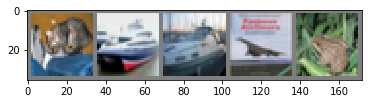

Labels: cat ship ship plane frog


In [22]:
# Show some test images
data_iter = iter(test_loader)
images, labels = data_iter.next()
imshow(torchvision.utils.make_grid(images[:NUM_IMAGES_TO_SHOW]))
print('Labels:', ' '.join(f'{classes[labels[i]]}' for i in range(NUM_IMAGES_TO_SHOW)))

In [23]:
# Predict classes for the random test images
outputs = net(images.to(device))
predictions = torch.argmax(outputs, 1)
print('predictions:', ' '.join(f'{classes[predictions[i]]}' for i in range(NUM_IMAGES_TO_SHOW)))

predictions: cat car ship plane frog


In [24]:
print('Accuracy of the model on the {} test images: {}%'.format(
    len(test_set), 100 * compute_test_accuracy()))

Accuracy of the model on the 10000 test images: 77.28%


In [25]:
# Check the accuracy per class
class_correct = np.zeros(len(classes))
class_total = np.zeros(len(classes))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        predictions = torch.argmax(outputs, 1)
        predictions_correct = (predictions == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += predictions_correct[i].item()
            class_total[label] += 1
for i in range(len(classes)):
    print('Accuracy of {}: [{:.0f}/{:.0f}] {:.1f}%'.format(
        classes[i], class_correct[i], class_total[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: [804/1000] 80.4%
Accuracy of car: [898/1000] 89.8%
Accuracy of bird: [702/1000] 70.2%
Accuracy of cat: [621/1000] 62.1%
Accuracy of deer: [755/1000] 75.5%
Accuracy of dog: [609/1000] 60.9%
Accuracy of frog: [859/1000] 85.9%
Accuracy of horse: [834/1000] 83.4%
Accuracy of ship: [875/1000] 87.5%
Accuracy of truck: [771/1000] 77.1%
